# Installing and First Simulation
## Introduction

This is the first Notebook of a series designed to explain the use of the first-passage time (FPT) package PyFPT, which uses importance sampling to find the probability of very rare events. The most recent version of PyFPT can be found at the following repository:
https://github.com/Jacks0nJ/PyFPT. There is also [documentation](https://pyfpt.readthedocs.io/en/latest/index.html) for this package.

For the uninitiated, an FPT problem is when we are interested in how long it takes for a random process to cross some specified threshold hold. For example, consider the classic 1D random walk of fixed step size on the $x$ axis. The walker can either make one step to the left (negative $x$ direction) or the right (positive $x$ direction). An FPT problem would be if there is an absorbing threshold at $x=10$, what is the average time taken to cross this threshold when the walker starts at $x=0$? While this exact problem can be calculated analytically, what about the probability of the rare event where it takes $10^4$ steps to reach this threshold? This is where importance sampling can be used, see [Mazonka *et al* 1998](https://arxiv.org/abs/nucl-th/9809075). The idea is to over sample the rare events (known as the sample distribution) and then weight them to recover the original distribution (known as the target distribution).

Numerically applying the importance sampling method to [Langevin](https://en.wikipedia.org/wiki/Langevin_equation) equations is the purpose of the PyFPT program. While the code is general, it was developed in the context of slow-roll stochastic inflation, see [Vennin+Starbinsky 2015](https://arxiv.org/abs/1506.04732), where the random process considered is the local duration of inflation in e-folds $N$ of a coarse-grained patch of the universe. Therefore, this guide focuses on applying the base PyFPT code, along with its additional functionality, to solving this problem. But hopefully by detailing PyFPT's functionality for this application, you can see how it could be applied to your FPT problem!

The PyFPT package contains analytical predictions of the probability density distribution to compare the numerical results against for the original problem of stochastic slow-roll inflation. These results are based on [Vennin+Starbinsky 2015](https://arxiv.org/abs/1506.04732) and [Pattison *et al* 2017](https://arxiv.org/abs/1707.00537). These tools will be detailed as they are introduced.

This Notebook will focus on the basics of installing PyFPT and looking at the simplest/most efficient simulation of large, but not dominating, diffusion effects. This is also known as the interim case. Part 2 will look at understanding the data and combining data sets and Part 3 at diffusion domination. As the use of the PyFPT package is the focus of this series of Notebooks, much of the discussion of the physics and statistics behind the code is limited to boxes labelled "Context".


**This guide provides the details of the key functionality of PyFPT, and in principle the provided code can be easily modified for your particular needs using the [documentation](https://pyfpt.readthedocs.io/en/latest/index.html).** But I hope you do stay to work through the rest of the guides, to fully understand both the capabilities (and limitations) of PyFPT. I've tried to make them as detailed as possible without being too long, so the experienced user will probably only need to skim read them.



Author: Joe Jackson

### Installing PyFPT

To install PyFPT in a Jupyter Notebook, simply use the pip install command below. To install it through the terminal, simply remove the `%`

`pip install --index-url https://test.pypi.org/simple/ --no-deps PyFPT==0.2.2`

It may take a few minutes to install. Make sure you have the prerequisite packages such as Cython alreadt installed. See the `setup.cfg` for details on the latest requirements.

In [1]:
%pip install --index-url https://test.pypi.org/simple/ --no-deps PyFPT==0.2.2

Looking in indexes: https://test.pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.


Now PyFPT is installed, let's import it along with the other packages we will need.

In [2]:
import pyfpt as fpt
import numpy as np
import matplotlib.pyplot as plt

import mpl_style
plt.style.use(mpl_style.paper_style)

NumPy will be used for data analysis and Matplotlib will be used for graphing. I've also installed my preferred style file for MatPlotlib, which is also available at the [PyFPT repository](https://github.com/Jacks0nJ/PyFPT). To import it, one simply downloads the file to same directory where this Notebook is run from.

## Example Potential - Quadratic
Let's now look at simulating the simple case of quadratic inflation, with a potential given by

$$
V(\phi) = \frac{m^2 \phi^2}{2} \, .
$$

The parameter $m$ determines the strength of the quantum diffusion: for $m \ll 1$ diffusion is sub-dominant and for $m \sim 1$ diffusion dominates. Depending on the value of $\phi$, there will also be an interim case with $m \lesssim 1$. Note units are such that $M_{PL}=1$.

To simulate this potential using PyFPT, the package the initial and end field values, $\phi_i$ and $\phi_{\rm end}$ respectively, will need to be defined. For the analytical comparisons, the potential as its derivatives are also needed

In [3]:
phi_in = 42**0.5  # From N=0.25*(phi_in**2-phi_end**2) = 10
phi_end = 2**0.5  # Where slow-roll violation occurs

# For the above phi_in, this mass is the interim case.
m = 0.1



def V(phi):
    V = 0.5*(m*phi)**2
    return V


def V_dif(phi):
    V_dif = (m**2)*phi
    return V_dif


def V_ddif(phi):
    V_ddif = (m**2)
    return V_ddif

The value of $\phi_{\rm end}$ is from the standard end condition for inflation, as at this field value the first slow-roll parameter reaches unity. The value for $\phi_i$ corresponds to 10 e-folds before the end of inflation if diffusion is ignored and for the purposes of this Notebook, is chosen to shorten the simulation time.

We could use the in-built functions to define the diffusion and drift, defined from the slow-roll Langevin equation

$$
\frac{\partial \bar{\phi}}{\partial N} = -\frac{1}{3H^2(\bar{\phi})} \frac{{\rm d} V(\bar{\phi})}{{\rm d}  \bar{\phi}}+\frac{H(\bar{\phi})}{2\pi}\xi \,,
$$
where
$$
H^2(\bar{\phi}) = \frac{V(\bar{\phi})}{3 M_{\rm PL}^2} \,,
$$

namely ``fpt.analytics.slow_roll_diffusion`` and ``fpt.analytics.slow_roll_drift``, respectively. But it is more efficent to define these functions directly from the definition of the Langevin equation, as this minimizes the interaction between FyPYT's cython (C) code and python. We will dicuss this more in the last Notebook. It might seem small, but this actually leads to an efficiency boost of $\sim 30 \%$.

In [4]:
def drift_func(phi, N):
    return -2/phi

def diffusion_func(phi, N):
    pi = 3.141592653589793
    sqirt_6 = 2.449489742783178
    return (m*phi)/(2*pi*sqirt_6)

### Context - Stochastic $\delta N$-formalism and Physical Intuition
The nature of FPT problem of stochastic inflation is not transparent. In stochastic inflation, a Langevin equation is used to describe the evolution of a single coarse-grained patch of the universe until the end of inflation value is reached. Therefore, the FPT corresponds to the local duration of inflation of a coarse-grained patch on the end of inflation surface if stochastic effects are non-negligible. The size of this patch will be very small compared to the observable universe. Using the $\delta N$-formalism, the difference between local duration of inflation and the average is the curvature perturbation

$$
\zeta = \mathcal{N}-\langle \mathcal{N} \rangle \, ,
$$

where the calligraphic $\mathcal{N}$ is the local FPT in e-folds of the considered coarse-grained patch, to differentiate it from the $N$ used as a time variable. Angle brackets are used to label an ensemble average. If one is interested in the probability of large perturbations on a scale larger than the coarse-grained patch on the end surface of inflation, the problem becomes much more complicated. See [Tado-Vennin 2021](https://arxiv.org/abs/2111.15280) and [Ando-Vennin 2020](https://arxiv.org/abs/2012.02031) for more discussion of the stochastic $\delta N$-formalism and perturbation scales.

### Interim Mass Case (`dN`)

As it is quick to simulate, while having some interesting numerical results, let's start by looking at the interim case. The required mass of $m=0.1$ is already used above. All of the code used here can be allied to smaller masses, but this would simply take longer to simulate.

To run the simulation, we need specify both the number of runs and bias used. Let's start with a small bias. More details about what this bias is will be given in Guide 2, but for now imagine it as a parameter determining how far into the tail of $P(\mathcal{N})$ the code simulates.

In [5]:
# The number of simulation runs
num_runs = 2*10**5
bias = 1.

Now we can simulate all of these runs using the default parameters. A full list of the optional parameters can be found in the PyFPT [documentation](https://pyfpt.readthedocs.io/en/latest/index.html). As PyFPT is a parallelized package, it outputs the number of cores used, as well as the time taken.

A sensible guess for `dN` is `dN = std/num_bins`, where `std` is the standard deviation of $\mathcal{N}$ in the low-diffsuion limit. As the code is very effcient, we can afford to be conservative and half this value to be on the safe side

In [6]:
# Estimate a reasonable time step to use
std = fpt.analytics.variance_efolds(V, V_dif, V_ddif, phi_in, phi_end)**0.5
dN = std/(2*50)

In [7]:
# Returns the normalised histogram bin centres, heights and
# errors as lists
bin_centres, heights, errors =\
    fpt.numerics.is_simulation(drift_func, diffusion_func, phi_in, phi_end, num_runs, bias, dN)


# Easier to use numpy arrays rather than lists
bin_centres = np.array(bin_centres)
heights = np.array(heights)
errors = np.array(errors)

Number of cores used: 4
The simulations took: 416.6357558080017 seconds


On my quad core Intel 8th gen i7 CPU, this took around 8 minutes. Try running this yourself. (If it displays some plots when you run it, don't worry, these are discussed in the next guide.)

The returned data is the bin centres, bin heights and their corresponding errors for a normalised histogram of the FPT in number of e-folds $N$. The heights of this histogram are therefore the probability densities. As the default parameters were used, there are 50 bins, with any bin with less than 400 data points within it truncated for accurate error estimation.

#### Graphing

Now let's graph this data using matplotlib.

Text(0, 0.5, '$P(\\mathcal{N})$')

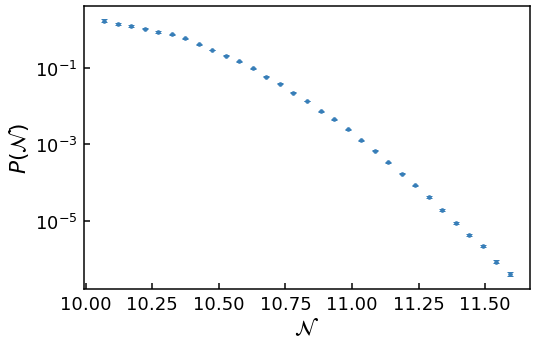

In [8]:
plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7)
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')

As we have sampled the tail, a log-scale has been used for the $y$-axis.

Now let's compare with the expectation if we assume a Gaussian distribution, which has a general form

$$
P(x) = \frac{1}{\sqrt{2\pi}\sigma} \exp{ \bigg[\frac{(x-\mu)^2}{2\sigma^2} \bigg]}\, ,
$$

where $\mu$ and $\sigma$ are the mean and standard deviation of the random variable $x$ respectively. The Gaussian expectation in the low-diffusion limit can be calculated from $V(\phi)$ using the methods detailed in [Vennin+Starbinsky 2015](https://arxiv.org/abs/1506.04732). Specifically, Eq. (3.28) is used to calculate the mean and Eq. (3.35) to calculate the standard deviation. This calculation is available in the analytics module of PyFPT as a function. It returns a function which calculates Gaussian probability density at a given $\mathcal{N}$ for the provided potential.

In [9]:
gaussian_pdf = fpt.analytics.gaussian_pdf(V, V_dif, V_ddif, phi_in, phi_end)

Now let's add this Gaussian curve to our plot and label both of them

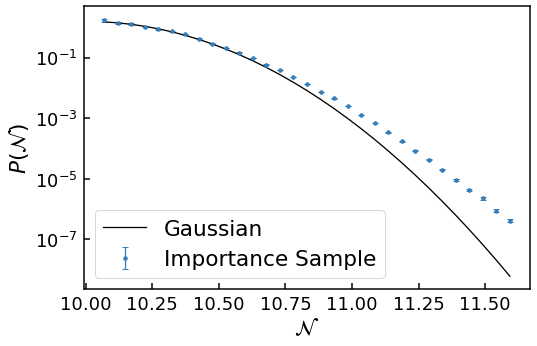

In [10]:
plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7,
             label='{0}'.format(r'Importance Sample'))
plt.plot(bin_centres, gaussian_pdf(bin_centres),
         label='{0}'.format('Gaussian'), color='k')
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')
plt.legend()

Clearly the numerical data diverges from the Gaussian expectation in the near tail.

However, we would expect this analytically, as when one calculates the skewness $\gamma$ and excess kurtosis $\kappa$, they deviate from the Gaussian values of 0. To include the non-zero skewness and excess kurtosis, for a normalised $x$ variable

$$
x \rightarrow \frac{x-\mu}{\sigma} \, ,
$$

the [Edgeworth series](https://en.wikipedia.org/wiki/Edgeworth_series) can be used

$$
P(x) \approx \frac{e^{-x^2/2}}{\sqrt{2\pi}}\bigg[ 1+\frac{\gamma}{6}He_3 (x) +\frac{\kappa}{24}He_4(x)  + \frac{\gamma^2}{72}He_6(x)  \bigg] \, ,
$$

where $He_3$, $He_4$ and $He_6$ are 3rd, 4th and 6th probabilist's [Hermite polynomials](https://en.wikipedia.org/wiki/Hermite_polynomials) respectively. This is also available in the analytics module of PyFPT in a similar manner to the Gaussian distribution.


In [11]:
edgeworth_pdf = fpt.analytics.edgeworth_pdf(V, V_dif, V_ddif, phi_in, phi_end)

Now let's see if this the Edgeworth series more accurately describes the tail of our numerical data.

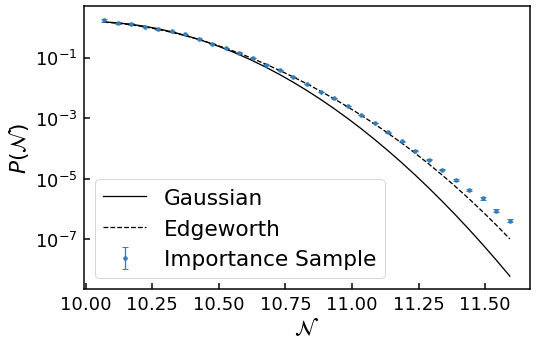

In [12]:
plt.errorbar(bin_centres, heights, yerr=errors, fmt=".", ms=7,
             label='{0}'.format(r'Importance Sample'))
plt.plot(bin_centres, gaussian_pdf(bin_centres),
         label='{0}'.format('Gaussian'), color='k')
plt.plot(bin_centres, edgeworth_pdf(bin_centres),
         label='{0}'.format('Edgeworth'), color='k',
        linestyle = 'dashed')
# Need to use log scale to see data in the far tail
plt.yscale('log')
plt.xlabel(r'$\mathcal{N}$')
plt.ylabel(r'$P(\mathcal{N})$')
plt.legend()

This is a definite improvement! Clearly the Edgeworth expansion more closely follows the numerical data before also deviating further into the near $\mathcal{N}=11.25$ or $P(\mathcal{N})\sim 10^{-4}$. Therefore, while the peak of the distribution is approximately given by a Gaussian distribution, and the near tail an Edgeworth expansion, the far tail behaviour can only be investigated numerically. (In principle one could calculate ever higher turns in the Edgeworth expansion, but this quicky becomes analytically too difficult).

## Guide 1 Conclusion
After explaining the motivation for PyFPt and a little about general first-passage time problems, we have installed and then used PyFPT to probe efficiently the tail of probability distribution. Then we compared it to analytical results assuming small diffusion effects and found that they do not describe the tail of the distribution. However, we did not go any further into the tail to see how much the numerical results deviate from the analytical expectations.

In Guide 2, we will use multiple importance samples to investigate both the near and far tail of the distribution, after gaining a better understanding of the raw data processed by PyFPT.